In [43]:
import geopandas as gpd
import pandas as pd
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

In [44]:
ROC_m1 = r'/Volumes/PhD/imagery/masters/ROC/M1_CT_ROC.shp'
ROC_m1 = gpd.read_file(ROC_m1)


ROC_msm1 = r'/Volumes/PhD/imagery/masters/output/ROC/MSM1_ROC.csv'
ROC_msm1 = pd.read_csv(ROC_msm1, index_col=0)
#ROC_msm1
ROC_m1.columns

Index(['BASIN_ID', 'Shape_Leng', 'Shape_Area', 'Segment_ID', 'Acc_Cl',
       'Perim_Buff', 'InsidePeri', 'OutsidePer', 'Fire_ID', 'Fire_Segme',
       'L_X1', 'L_X2', 'L_X3', 'V_X1', 'V_X2', 'Shape_Le_1', 'R', 'V_X3', 'X',
       'ExpX', 'P', 'PCl', 'PCl_Legend', 'LnV', 'Volume', 'VolMin', 'VolMax',
       'VolCl', 'VolCl_Lege', 'CombHaz', 'CombHazCl', 'CombHazCl_', 'area',
       'Field', 'ROC', 'nearest_st', 'distance_t', 'RI_index', 'RI',
       'Mean_dNBR', 'Med_dNBR', 'PF_dNBR', 'M1P_Mean', 'M1P_Med', 'M1p_PF',
       'geometry'],
      dtype='object')

In [45]:
ROC_df = {
    'BASIN_ID': ROC_m1['BASIN_ID'],
    'AREA': ROC_m1['Shape_Area'],
    'M1P_Mean': ROC_m1['M1P_Mean'],
    'M1P_Med': ROC_m1['M1P_Med'],
    'M1P_PF': ROC_m1['M1p_PF'],
    'MSM1P_Mean': ROC_msm1['MSM1P_Mean'],
    'MSM1P_Med': ROC_msm1['MSM1P_Med'],
    'MSM1P_PF': ROC_msm1['MSM1P_PF'],
    'MSM1Pct_>50': ROC_msm1['MSM1_>50'],
    'MSM1Pct_>90': ROC_msm1['MSM1_>90'],
    'RI': ROC_m1['RI'],
    'Old_ROC': ROC_m1['Field']
}
ROC_df = pd.DataFrame(ROC_df)
ROC_df
non_normal_copy = ROC_df

In [46]:
#Ground truth category
ROC_df['DF'] = ROC_df['Old_ROC'].apply(lambda x: 1 if x == 1 or x == 2 else 0)

#M1 ROC setup
ROC_df['M1_Mean_50'] = ROC_df['M1P_Mean'].apply(lambda x: 1 if x > 0.5 else 0)
ROC_df['M1_Med_50'] = ROC_df['M1P_Med'].apply(lambda x: 1 if x > 0.5 else 0)
ROC_df['M1_PF_50'] = ROC_df['M1P_PF'].apply(lambda x: 1 if x > 0.5 else 0)
ROC_df['M1_Mean_60'] = ROC_df['M1P_Mean'].apply(lambda x: 1 if x > 0.6 else 0)
ROC_df['M1_Med_60'] = ROC_df['M1P_Med'].apply(lambda x: 1 if x > 0.6 else 0)
ROC_df['M1_PF_60'] = ROC_df['M1P_PF'].apply(lambda x: 1 if x > 0.6 else 0)
ROC_df['M1_Mean_70'] = ROC_df['M1P_Mean'].apply(lambda x: 1 if x > 0.7 else 0)
ROC_df['M1_Med_70'] = ROC_df['M1P_Med'].apply(lambda x: 1 if x > 0.7 else 0)
ROC_df['M1_PF_70'] = ROC_df['M1P_PF'].apply(lambda x: 1 if x > 0.7 else 0)
ROC_df['M1_Mean_80'] = ROC_df['M1P_Mean'].apply(lambda x: 1 if x > 0.8 else 0)
ROC_df['M1_Med_80'] = ROC_df['M1P_Med'].apply(lambda x: 1 if x > 0.8 else 0)
ROC_df['M1_PF_80'] = ROC_df['M1P_PF'].apply(lambda x: 1 if x > 0.8 else 0)
ROC_df['M1_Mean_90'] = ROC_df['M1P_Mean'].apply(lambda x: 1 if x > 0.9 else 0)
ROC_df['M1_Med_90'] = ROC_df['M1P_Med'].apply(lambda x: 1 if x > 0.9 else 0)
ROC_df['M1_PF_90'] = ROC_df['M1P_PF'].apply(lambda x: 1 if x > 0.9 else 0)

#MSM1 ROC setup
ROC_df['MSM1_Mean_50'] = ROC_df['MSM1P_Mean'].apply(lambda x: 1 if x > 0.5 else 0)
ROC_df['MSM1_Med_50'] = ROC_df['MSM1P_Med'].apply(lambda x: 1 if x > 0.5 else 0)
ROC_df['MSM1_PF_50'] = ROC_df['MSM1P_PF'].apply(lambda x: 1 if x > 0.5 else 0)
ROC_df['MSM1_Mean_60'] = ROC_df['MSM1P_Mean'].apply(lambda x: 1 if x > 0.6 else 0)
ROC_df['MSM1_Med_60'] = ROC_df['MSM1P_Med'].apply(lambda x: 1 if x > 0.6 else 0)
ROC_df['MSM1_PF_60'] = ROC_df['MSM1P_PF'].apply(lambda x: 1 if x > 0.6 else 0)
ROC_df['MSM1_Mean_70'] = ROC_df['MSM1P_Mean'].apply(lambda x: 1 if x > 0.7 else 0)
ROC_df['MSM1_Med_70'] = ROC_df['MSM1P_Med'].apply(lambda x: 1 if x > 0.7 else 0)
ROC_df['MSM1_PF_70'] = ROC_df['MSM1P_PF'].apply(lambda x: 1 if x > 0.7 else 0)
ROC_df['MSM1_Mean_80'] = ROC_df['MSM1P_Mean'].apply(lambda x: 1 if x > 0.8 else 0)
ROC_df['MSM1_Med_80'] = ROC_df['MSM1P_Med'].apply(lambda x: 1 if x > 0.8 else 0)
ROC_df['MSM1_PF_80'] = ROC_df['MSM1P_PF'].apply(lambda x: 1 if x > 0.8 else 0)
ROC_df['MSM1_Mean_90'] = ROC_df['MSM1P_Mean'].apply(lambda x: 1 if x > 0.9 else 0)
ROC_df['MSM1_Med_90'] = ROC_df['MSM1P_Med'].apply(lambda x: 1 if x > 0.9 else 0)
ROC_df['MSM1_PF_90'] = ROC_df['MSM1P_PF'].apply(lambda x: 1 if x > 0.9 else 0)

#MSM1 ROC basin pct above 50 & 90 setup

ROC_df['MSM1_Pct_50'] = ROC_df['MSM1Pct_>50'].apply(lambda x: 1 if x > 0.5 else 0)
ROC_df['MSM1_Pct_90'] = ROC_df['MSM1Pct_>90'].apply(lambda x: 1 if x > 0.5 else 0)


In [48]:
ROC_df

,BASIN_ID,AREA,M1P_Mean,M1P_Med,M1P_PF,MSM1P_Mean,MSM1P_Med,MSM1P_PF,MSM1Pct_>50,MSM1Pct_>90,...,MSM1_Med_70,MSM1_PF_70,MSM1_Mean_80,MSM1_Med_80,MSM1_PF_80,MSM1_Mean_90,MSM1_Med_90,MSM1_PF_90,MSM1_Pct_50,MSM1_Pct_90
0,17499,1.429800e+06,0.449618,0.454098,0.438860,0.452268,0.454098,0.434946,0.338655,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,3115,4.180000e+04,0.148129,0.116710,0.101142,0.167113,0.116710,0.103580,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,3589,4.313000e+05,0.301476,0.164258,0.122691,0.347361,0.164258,0.126322,0.350926,0.000926,...,0,0,0,0,0,0,0,0,0,0
3,5683,5.659000e+05,0.999180,0.999251,0.999382,0.998348,0.999251,0.999311,1.000000,1.000000,...,1,1,1,1,1,1,1,1,1,1
4,5920,7.486600e+06,0.848432,0.870989,0.910869,0.816237,0.870989,0.913444,0.939107,0.355948,...,1,1,1,1,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,15065,9.550000e+04,0.313190,0.248063,0.189564,0.340194,0.248064,0.187487,0.258333,0.000000,...,0,0,0,0,0,0,0,0,0,0
733,35852,8.360000e+04,0.473049,0.466838,0.444912,0.473233,0.466838,0.442397,0.297561,0.000000,...,0,0,0,0,0,0,0,0,0,0
734,36553,4.570000e+04,0.468316,0.457159,0.448097,0.468544,0.457159,0.447535,0.286957,0.000000,...,0,0,0,0,0,0,0,0,0,0
735,36955,1.098000e+05,0.281668,0.274903,0.249830,0.293276,0.274903,0.235123,0.036496,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
ROC_df.to_csv(r'/Volumes/PhD/imagery/masters/ROC/M1-MSM1_ROC.csv')
large_basins_df = ROC_df[ROC_df['AREA'] >= 1000000]
small_basins_df = ROC_df[ROC_df['AREA'] <= 1000000]


,BASIN_ID,AREA,M1P_Mean,M1P_Med,M1P_PF,MSM1P_Mean,MSM1P_Med,MSM1P_PF,MSM1Pct_>50,MSM1Pct_>90,...,M1_Med_90,M1_PF_90,MSM1_Mean_50,MSM1_Med_50,MSM1_PF_50,MSM1_Mean_90,MSM1_Med_90,MSM1_PF_90,MSM1_Pct_50,MSM1_Pct_90
0,17499,1429800.0,0.449618,0.454098,0.438860,0.452268,0.454098,0.434946,0.338655,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,5920,7486600.0,0.848432,0.870989,0.910869,0.816237,0.870989,0.913444,0.939107,0.355948,...,0,1,1,1,1,0,0,1,1,0
5,7185,4314900.0,0.866735,0.877320,0.904633,0.848268,0.877320,0.913230,0.992119,0.361487,...,0,1,1,1,1,0,0,1,1,0
6,7262,1879000.0,0.996406,0.997266,0.997908,0.992745,0.997266,0.997419,1.000000,0.994470,...,1,1,1,1,1,1,1,1,1,1
8,10814,1592100.0,0.999730,0.999774,0.999894,0.999441,0.999774,0.999851,1.000000,1.000000,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640,33785,7967600.0,0.460076,0.453885,0.446750,0.463044,0.453885,0.441122,0.383758,0.000050,...,0,0,0,0,0,0,0,0,0,0
668,24647,1292500.0,0.133912,0.133626,0.133514,0.138023,0.133626,0.112121,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
671,25293,1465000.0,0.098651,0.102929,0.120119,0.103559,0.102929,0.065637,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
676,28113,2412800.0,0.074746,0.077836,0.086603,0.077261,0.077836,0.085151,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [54]:
def compute_roc(df, ground_truth, prediction_col):
    results = []

    for pred_col in prediction_col:
        TP = ((df[ground_truth] == 1) & (df[pred_col] == 1)).sum()
        FP = ((df[ground_truth] == 0) & (df[pred_col] == 1)).sum()
        TN = ((df[ground_truth] == 0) & (df[pred_col] == 0)).sum()
        FN = ((df[ground_truth] == 1) & (df[pred_col] == 0)).sum()

        TPR = TP / (TP + FN) if (TP + FN) != 0 else 0
        FPR = FP / (FP + TN) if (FP + TN) != 0 else 0
        SPC = TN / (TN + FP)
        ACC = (TP + TN) / (TP + TN + FP + FN)
        THT = TP / (TP + FP + FN)

        # Calculate AUC using scikit-learn's roc_curve and auc functions
        fpr, tpr, _ = roc_curve(df[ground_truth], df[pred_col])
        roc_auc = auc(fpr, tpr)

        # Append results
        results.append({
            "Prediction Column": pred_col,
            "TP": TP,
            "FP": FP,
            "TN": TN,
            "FN": FN,
            "Sensitivity": TPR,
            "FPR": FPR,
            'Specificity': SPC,
            'Accuracy': ACC,
            "AUC": roc_auc,
            'Threat Score': THT
        })
    return pd.DataFrame(results)

In [51]:
columns_after_df = ROC_df.columns[ROC_df.columns.get_loc('DF') + 1:]
columns_after_df


Index(['M1_Mean_50', 'M1_Med_50', 'M1_PF_50', 'M1_Mean_60', 'M1_Med_60',
       'M1_PF_60', 'M1_Mean_70', 'M1_Med_70', 'M1_PF_70', 'M1_Mean_80',
       'M1_Med_80', 'M1_PF_80', 'M1_Mean_90', 'M1_Med_90', 'M1_PF_90',
       'MSM1_Mean_50', 'MSM1_Med_50', 'MSM1_PF_50', 'MSM1_Mean_60',
       'MSM1_Med_60', 'MSM1_PF_60', 'MSM1_Mean_70', 'MSM1_Med_70',
       'MSM1_PF_70', 'MSM1_Mean_80', 'MSM1_Med_80', 'MSM1_PF_80',
       'MSM1_Mean_90', 'MSM1_Med_90', 'MSM1_PF_90', 'MSM1_Pct_50',
       'MSM1_Pct_90'],
      dtype='object')

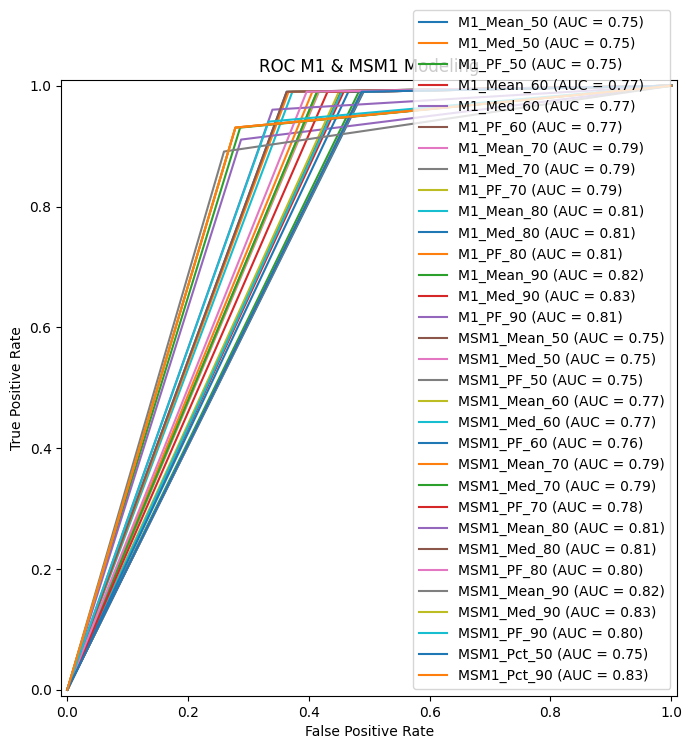

In [55]:
ground_truth_col = 'DF'
roc_results = compute_roc(ROC_df, ground_truth_col, columns_after_df)



# Optional: Plot ROC curves for each column
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
for pred_col in columns_after_df:
    fpr, tpr, _ = roc_curve(ROC_df['DF'], ROC_df[pred_col])
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc(fpr, tpr), estimator_name=pred_col).plot(ax=plt.gca())

plt.title('ROC M1 & MSM1 Modeling')
plt.legend(loc='lower right')
plt.show()

In [56]:
roc_results


,Prediction Column,TP,FP,TN,FN,Sensitivity,FPR,Specificity,Accuracy,AUC,Threat Score
0,M1_Mean_50,100,312,324,1,0.990099,0.490566,0.509434,0.575305,0.749766,0.242131
1,M1_Med_50,100,310,326,1,0.990099,0.487421,0.512579,0.578019,0.751339,0.243309
2,M1_PF_50,100,307,329,1,0.990099,0.482704,0.517296,0.582090,0.753697,0.245098
3,M1_Mean_60,100,291,345,1,0.990099,0.457547,0.542453,0.603799,0.766276,0.255102
4,M1_Med_60,100,289,347,1,0.990099,0.454403,0.545597,0.606513,0.767848,0.256410
5,M1_PF_60,100,288,348,1,0.990099,0.452830,0.547170,0.607870,0.768634,0.257069
6,M1_Mean_70,100,265,371,1,0.990099,0.416667,0.583333,0.639077,0.786716,0.273224
7,M1_Med_70,100,263,373,1,0.990099,0.413522,0.586478,0.641791,0.788288,0.274725
8,M1_PF_70,100,264,372,1,0.990099,0.415094,0.584906,0.640434,0.787502,0.273973
9,M1_Mean_80,100,237,399,1,0.990099,0.372642,0.627358,0.677069,0.808729,0.295858


In [27]:
roc_results.to_csv(r'/Volumes/PhD/imagery/masters/ROC/M1-MSM1_ROC_results.csv')


In [14]:
small_results = compute_roc(small_basins_df, ground_truth_col, columns_after_df)
small_results

,Prediction Column,TP,FP,TN,FN,Sensitivity,FPR,Specificity,Accuracy,AUC,Threat Score
0,M1_Mean_50,64,280,288,0,1.000000,0.492958,0.507042,0.556962,0.753521,0.101266
1,M1_Med_50,64,277,291,0,1.000000,0.487676,0.512324,0.561709,0.756162,0.101266
2,M1_PF_50,64,272,296,0,1.000000,0.478873,0.521127,0.569620,0.760563,0.101266
3,M1_Mean_90,61,169,399,3,0.953125,0.297535,0.702465,0.727848,0.827795,0.096519
4,M1_Med_90,61,163,405,3,0.953125,0.286972,0.713028,0.737342,0.833077,0.096519
5,M1_PF_90,59,166,402,5,0.921875,0.292254,0.707746,0.729430,0.814811,0.093354
6,MSM1_Mean_50,64,279,289,0,1.000000,0.491197,0.508803,0.558544,0.754401,0.101266
7,MSM1_Med_50,64,277,291,0,1.000000,0.487676,0.512324,0.561709,0.756162,0.101266
8,MSM1_PF_50,64,276,292,0,1.000000,0.485915,0.514085,0.563291,0.757042,0.101266
9,MSM1_Mean_90,57,152,416,7,0.890625,0.267606,0.732394,0.748418,0.811510,0.090190


In [15]:
large_results = compute_roc(large_basins_df, ground_truth_col, columns_after_df)
large_results

,Prediction Column,TP,FP,TN,FN,Sensitivity,FPR,Specificity,Accuracy,AUC,Threat Score
0,M1_Mean_50,36,32,36,1,0.972973,0.470588,0.529412,0.685714,0.751192,0.342857
1,M1_Med_50,36,33,35,1,0.972973,0.485294,0.514706,0.676190,0.743839,0.342857
2,M1_PF_50,36,35,33,1,0.972973,0.514706,0.485294,0.657143,0.729134,0.342857
3,M1_Mean_90,33,13,55,4,0.891892,0.191176,0.808824,0.838095,0.850358,0.314286
4,M1_Med_90,33,14,54,4,0.891892,0.205882,0.794118,0.828571,0.843005,0.314286
5,M1_PF_90,33,17,51,4,0.891892,0.250000,0.750000,0.800000,0.820946,0.314286
6,MSM1_Mean_50,36,32,36,1,0.972973,0.470588,0.529412,0.685714,0.751192,0.342857
7,MSM1_Med_50,36,33,35,1,0.972973,0.485294,0.514706,0.676190,0.743839,0.342857
8,MSM1_PF_50,36,35,33,1,0.972973,0.514706,0.485294,0.657143,0.729134,0.342857
9,MSM1_Mean_90,33,13,55,4,0.891892,0.191176,0.808824,0.838095,0.850358,0.314286


In [16]:
small_results.to_csv(r'/Volumes/PhD/imagery/masters/ROC/M1-MSM1_ROC_small-results.csv')
large_results.to_csv(r'/Volumes/PhD/imagery/masters/ROC/M1-MSM1_ROC_large-results.csv')

In [22]:
non_normal = pd.read_csv(r'/Volumes/PhD/imagery/masters/ROC/non-normal_roc.csv')
non_normal

,BASIN_ID,Skewed/Bimodal
0,2476,1
1,2747,0
2,2760,1
3,2832,0
4,3115,0
...,...,...
180,41594,1
181,41639,0
182,41709,1
183,41846,1


In [29]:
subset_ids = non_normal['BASIN_ID']

subset_df = ROC_df[ROC_df['BASIN_ID'].isin(subset_ids)]
NN_df = subset_df.merge(non_normal[['BASIN_ID', 'Skewed/Bimodal']], on='BASIN_ID', how='left')
#NN_df = NN_df.merge(ROC_df, on='BASIN_ID', how='left')
NN_df


,BASIN_ID,AREA,M1P_Mean,M1P_Med,M1P_PF,MSM1P_Mean,MSM1P_Med,MSM1P_PF,MSM1Pct_>50,MSM1Pct_>90,RI,Old_ROC,Skewed/Bimodal
0,3115,4.180000e+04,0.148129,0.116710,0.101142,0.167113,0.116710,0.103580,0.000000,0.000000,7.11,4,0
1,3589,4.313000e+05,0.301476,0.164258,0.122691,0.347361,0.164258,0.126322,0.350926,0.000926,7.11,4,1
2,5920,7.486600e+06,0.848432,0.870989,0.910869,0.816237,0.870989,0.913444,0.939107,0.355948,6.10,4,0
3,7185,4.314900e+06,0.866735,0.877320,0.904633,0.848268,0.877320,0.913230,0.992119,0.361487,6.10,4,0
4,12918,3.022200e+06,0.915269,0.923432,0.932539,0.903513,0.923432,0.936069,0.998809,0.701072,6.10,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,6542,2.562000e+05,0.169919,0.128443,0.121494,0.191700,0.128443,0.124673,0.068858,0.000000,6.10,0,0
177,18288,7.025000e+05,0.141669,0.147208,0.156382,0.156227,0.147208,0.080448,0.000568,0.000000,5.08,0,0
178,19058,2.172000e+05,0.123042,0.096739,0.076722,0.138916,0.096739,0.077806,0.000000,0.000000,5.08,0,1
179,15065,9.550000e+04,0.313190,0.248063,0.189564,0.340194,0.248064,0.187487,0.258333,0.000000,9.14,0,1


In [42]:
#Ground truth category
NN_df['DF'] = NN_df['Old_ROC'].apply(lambda x: 1 if x == 1 or x == 2 else 0)

#M1 ROC setup
NN_df['M1_Mean_50'] = NN_df['M1P_Mean'].apply(lambda x: 1 if x > 0.5 else 0)
NN_df['M1_Med_50'] = NN_df['M1P_Med'].apply(lambda x: 1 if x > 0.5 else 0)
NN_df['M1_PF_50'] = NN_df['M1P_PF'].apply(lambda x: 1 if x > 0.5 else 0)
NN_df['M1_Mean_90'] = NN_df['M1P_Mean'].apply(lambda x: 1 if x > 0.9 else 0)
NN_df['M1_Med_90'] = NN_df['M1P_Med'].apply(lambda x: 1 if x > 0.9 else 0)
NN_df['M1_PF_90'] = NN_df['M1P_PF'].apply(lambda x: 1 if x > 0.9 else 0)

#MSM1 ROC setup
NN_df['MSM1_Mean_50'] = NN_df['MSM1P_Mean'].apply(lambda x: 1 if x > 0.5 else 0)
NN_df['MSM1_Med_50'] = NN_df['MSM1P_Med'].apply(lambda x: 1 if x > 0.5 else 0)
NN_df['MSM1_PF_50'] = NN_df['MSM1P_PF'].apply(lambda x: 1 if x > 0.5 else 0)
NN_df['MSM1_Mean_90'] = NN_df['MSM1P_Mean'].apply(lambda x: 1 if x > 0.9 else 0)
NN_df['MSM1_Med_90'] = NN_df['MSM1P_Med'].apply(lambda x: 1 if x > 0.9 else 0)
NN_df['MSM1_PF_90'] = NN_df['MSM1P_PF'].apply(lambda x: 1 if x > 0.9 else 0)

#MSM1 ROC basin pct above 50 & 90 setup

NN_df['MSM1_Pct_50'] = NN_df['MSM1Pct_>50'].apply(lambda x: 1 if x > 0.5 else 0)
NN_df['MSM1_Pct_90'] = NN_df['MSM1Pct_>90'].apply(lambda x: 1 if x > 0.5 else 0)

In [34]:
NN_df.columns

Index(['BASIN_ID', 'AREA', 'M1P_Mean', 'M1P_Med', 'M1P_PF', 'MSM1P_Mean',
       'MSM1P_Med', 'MSM1P_PF', 'MSM1Pct_>50', 'MSM1Pct_>90', 'RI', 'Old_ROC',
       'Skewed/Bimodal', 'DF', 'M1_Mean_50', 'M1_Med_50', 'M1_PF_50',
       'M1_Mean_90', 'M1_Med_90', 'M1_PF_90', 'MSM1_Mean_50', 'MSM1_Med_50',
       'MSM1_PF_50', 'MSM1_Mean_90', 'MSM1_Med_90', 'MSM1_PF_90',
       'MSM1_Pct_50', 'MSM1_Pct_90'],
      dtype='object')

In [41]:
skewed_basins_df = NN_df[NN_df['Skewed/Bimodal'] == 0]
bimodal_basins_df = NN_df[NN_df['Skewed/Bimodal'] == 1]

bimodal_basins_df.to_csv(r'/Volumes/PhD/imagery/masters/ROC/bimodal.csv')

In [37]:
NNroc_results = compute_roc(NN_df, ground_truth_col, columns_after_df)
NNroc_results


,Prediction Column,TP,FP,TN,FN,Sensitivity,FPR,Specificity,Accuracy,AUC,Threat Score
0,M1_Mean_50,15,112,54,0,1.000000,0.674699,0.325301,0.381215,0.662651,0.082873
1,M1_Med_50,15,111,55,0,1.000000,0.668675,0.331325,0.386740,0.665663,0.082873
2,M1_PF_50,15,106,60,0,1.000000,0.638554,0.361446,0.414365,0.680723,0.082873
3,M1_Mean_90,10,39,127,5,0.666667,0.234940,0.765060,0.756906,0.715863,0.055249
4,M1_Med_90,10,37,129,5,0.666667,0.222892,0.777108,0.767956,0.721888,0.055249
5,M1_PF_90,8,43,123,7,0.533333,0.259036,0.740964,0.723757,0.637149,0.044199
6,MSM1_Mean_50,15,111,55,0,1.000000,0.668675,0.331325,0.386740,0.665663,0.082873
7,MSM1_Med_50,15,111,55,0,1.000000,0.668675,0.331325,0.386740,0.665663,0.082873
8,MSM1_PF_50,15,110,56,0,1.000000,0.662651,0.337349,0.392265,0.668675,0.082873
9,MSM1_Mean_90,6,25,141,9,0.400000,0.150602,0.849398,0.812155,0.624699,0.033149


In [38]:
skew_results = compute_roc(skewed_basins_df, ground_truth_col, columns_after_df)
skew_results

,Prediction Column,TP,FP,TN,FN,Sensitivity,FPR,Specificity,Accuracy,AUC,Threat Score
0,M1_Mean_50,15,84,26,0,1.000000,0.763636,0.236364,0.328,0.618182,0.120
1,M1_Med_50,15,83,27,0,1.000000,0.754545,0.245455,0.336,0.622727,0.120
2,M1_PF_50,15,82,28,0,1.000000,0.745455,0.254545,0.344,0.627273,0.120
3,M1_Mean_90,10,34,76,5,0.666667,0.309091,0.690909,0.688,0.678788,0.080
4,M1_Med_90,10,33,77,5,0.666667,0.300000,0.700000,0.696,0.683333,0.080
5,M1_PF_90,8,38,72,7,0.533333,0.345455,0.654545,0.640,0.593939,0.064
6,MSM1_Mean_50,15,84,26,0,1.000000,0.763636,0.236364,0.328,0.618182,0.120
7,MSM1_Med_50,15,83,27,0,1.000000,0.754545,0.245455,0.336,0.622727,0.120
8,MSM1_PF_50,15,82,28,0,1.000000,0.745455,0.254545,0.344,0.627273,0.120
9,MSM1_Mean_90,6,24,86,9,0.400000,0.218182,0.781818,0.736,0.590909,0.048


In [39]:
bimodal_results = compute_roc(bimodal_basins_df, ground_truth_col, columns_after_df)
bimodal_results

/Users/samueltaylor/Documents/GitHub/PHA_burn_severity/.venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/samueltaylor/Documents/GitHub/PHA_burn_severity/.venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/samueltaylor/Documents/GitHub/PHA_burn_severity/.venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/samueltaylor/Documents/GitHub/PHA_burn_severity/.venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/samueltaylor/Documents/GitHub/PHA_burn_severi

,Prediction Column,TP,FP,TN,FN,Sensitivity,FPR,Specificity,Accuracy,AUC,Threat Score
0,M1_Mean_50,0,28,28,0,0,0.500000,0.500000,0.500000,NaN,0.0
1,M1_Med_50,0,28,28,0,0,0.500000,0.500000,0.500000,NaN,0.0
2,M1_PF_50,0,24,32,0,0,0.428571,0.571429,0.571429,NaN,0.0
3,M1_Mean_90,0,5,51,0,0,0.089286,0.910714,0.910714,NaN,0.0
4,M1_Med_90,0,4,52,0,0,0.071429,0.928571,0.928571,NaN,0.0
5,M1_PF_90,0,5,51,0,0,0.089286,0.910714,0.910714,NaN,0.0
6,MSM1_Mean_50,0,27,29,0,0,0.482143,0.517857,0.517857,NaN,0.0
7,MSM1_Med_50,0,28,28,0,0,0.500000,0.500000,0.500000,NaN,0.0
8,MSM1_PF_50,0,28,28,0,0,0.500000,0.500000,0.500000,NaN,0.0
9,MSM1_Mean_90,0,1,55,0,0,0.017857,0.982143,0.982143,NaN,0.0
